In [1]:
import keras
from keras.models import Model
from keras.layers import *
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = (72, 72, 3)
BATCH_SIZE = 256
NUM_CLASSES = 10

PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE[0] // PATCH_SIZE) ** 2
PATCH_W = IMAGE_SIZE[0] // PATCH_SIZE

CLASS_DICT = {
   0: "airplane",
   1: "automobile",
   2: "bird",
   3: "cat",
   4: "deer",
   5: "dog",
   6: "frog",
   7: "horse",
   8: "ship",
   9: "truck"
}

# DATA

### Downloading the Dataset

In [ ]:
(x_train,y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

### Preprocessing the Dataset

In [4]:
def process(img, c):
    return tf.cast(tf.image.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])), tf.uint8), c

In [5]:
y_train, y_test = keras.utils.to_categorical(y_train, NUM_CLASSES), keras.utils.to_categorical(y_test, NUM_CLASSES)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(process).shuffle(5000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(process).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(256, 72, 72, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(256, 72, 72, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>)

### Testing the Dataset

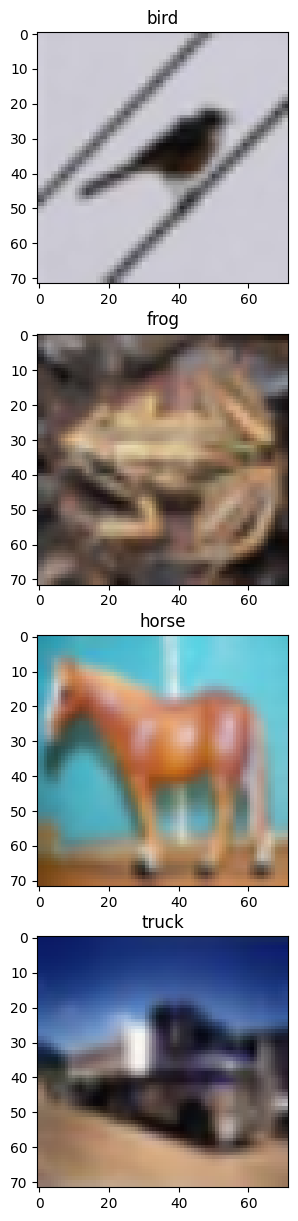

In [ ]:
samples = test_ds.as_numpy_iterator().next()

fig, axes = plt.subplots(4, 1, figsize=(7, 15))
for i in range(4):
    axes[i].imshow(samples[0][i])
    axes[i].title.set_text(CLASS_DICT[np.argmax(samples[1][i])])

### Generating the Patches

In [7]:
class PatchExtractor(keras.layers.Layer):
  def __init__(self):
    super(PatchExtractor, self).__init__()
    self.patch_size = PATCH_SIZE

  def call(self, images):
    patches = tf.image.extract_patches(images, [1,self.patch_size,self.patch_size,1], [1,self.patch_size,self.patch_size,1], [1,1,1,1], padding='VALID')
    return tf.reshape(
            patches,
            (
                BATCH_SIZE,
                PATCH_W * PATCH_W,
                self.patch_size * self.patch_size * 3,
            ),
        )
    return patches

### Testing the Patches

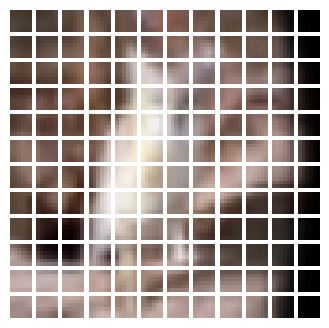

In [8]:
samples = PatchExtractor()(test_ds.as_numpy_iterator().next()[0])

n = int(np.sqrt(samples.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(samples[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img)
    plt.axis("off")

# MODEL

### Building the Model

In [ ]:
class ViT(Model):
    def __init__(self):
        super(ViT, self).__init__()

        self.positions = tf.expand_dims(tf.range(start=0, limit=NUM_PATCHES, delta=1), axis=0)
        self.vit = self.build_vit_classifier()

    def build_vit_classifier(self):
        def patch_encoder(input):

            x = Dense(64)(input)
            y = Embedding(NUM_PATCHES, 64)(self.positions)
            return x + y

        def mlp(units, drop_rate, input):
            x = Dense(units, activation=keras.activations.gelu)(input)
            x = Dropout(drop_rate)(x)
            x = Dense(units//2, activation=keras.activations.gelu)(x)
            return Dropout(drop_rate)(x)

        input = Input((IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]))

        x = PatchExtractor()(input)          # Creating the patches
        x = patch_encoder(x)           # Encoding the patches

        for _ in range(12):                  # Transformer layers
            y = LayerNormalization(epsilon=1e-6)(x)
            y = MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.1)(y, y)
            z = Add()([y, x])
            x3 = LayerNormalization(epsilon=1e-6)(z)
            x3 = mlp(128, 0.1, x3)
            x = Add()([x3, z])

        x = LayerNormalization(epsilon=1e-6)(x)
        x = Flatten()(x)
        x = mlp(2048, 0.5, x)
        out = Dense(NUM_CLASSES, activation='softmax')(x)

        return Model(inputs=input, outputs=out)


In [ ]:
model = ViT().vit
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extractor_7   │ (256, 144, 108)   │          0 │ input_layer_2[0]… │
│ (PatchExtractor)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (256, 144, 64)    │      6,976 │ patch_extractor_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (256, 144, 64)    │          0 │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (256, 144, 64)    │        128 │ add_50[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (256, 144, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (256, 144, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (256, 144, 64)    │        128 │ add_51[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (256, 144, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (256, 144, 128)   │          0 │ dense_57[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (256, 144, 64)    │      8,256 │ dropout_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (256, 144, 64)    │          0 │ dense_58[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (256, 144, 64)    │          0 │ dropout_52[0][0], │
│                     │                   │            │ add_51[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (256, 144, 64)    │        128 │ add_52[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (256, 144, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_53 (Add)        │ (256, 144, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_52[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (256, 144, 64)    │        128 │ add_53[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (256, 144, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,990,346 (83.89 MB)

 Trainable params: 21,990,346 (83.89 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
  1/195 ━━━━━━━━━━━━━━━━━━━━ 5:26:50 101s/step - accuracy: 0.1094 - loss: 3.6789

W0000 00:00:1709989228.749054     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.1613 - loss: 5.6532

W0000 00:00:1709989271.223646     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/195 ━━━━━━━━━━━━━━━━━━━━ 146s 229ms/step - accuracy: 0.1614 - loss: 5.6399 - val_accuracy: 0.2376 - val_loss: 2.0357
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.1837 - loss: 2.1214 - val_accuracy: 0.2909 - val_loss: 1.8766
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.2433 - loss: 1.9797 - val_accuracy: 0.3144 - val_loss: 1.8245
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.2980 - loss: 1.8559 - val_accuracy: 0.4075 - val_loss: 1.6977
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.3669 - loss: 1.6932 - val_accuracy: 0.4310 - val_loss: 1.5830
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - accuracy: 0.4232 - loss: 1.5370 - val_accuracy: 0.5117 - val_loss: 1.4299
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - accuracy: 0.4746 - loss: 1.4208 - val_accuracy: 0.5557 - val_loss: 1.3116
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - accuracy: 0.5253 - loss: 1.2988 - va

### Testing the Model

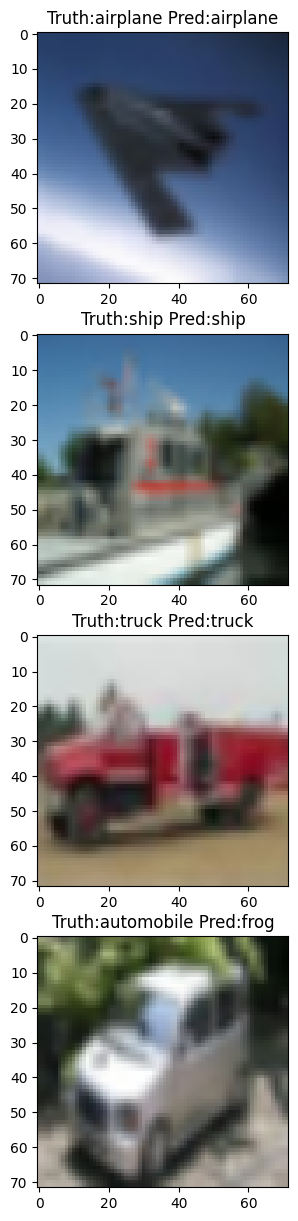

In [ ]:
samples = test_ds.as_numpy_iterator().next()
results = model(samples[0])

fig, axes = plt.subplots(4, 1, figsize=(4, 15))
for i in range(4):
    axes[i].imshow(samples[0][i])
    axes[i].title.set_text(f'Truth:{CLASS_DICT[np.argmax(samples[1][i])]} Pred:{CLASS_DICT[np.argmax(results[i])]}')

### Saving the Model

In [ ]:
model.save("ViT.h5")